<a href="https://colab.research.google.com/github/anasruzh/ML_RSM_ARR/blob/anas_primera_entrega_bulling/ejercicio1_bullying1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================
# PROYECTO: Detección de Bullying Escolar
# ==============================================

# 1. Importación de librerías
import pandas as pd
import numpy as np

# Preprocesamiento
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Métricas de evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Manejo del desbalanceo
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



In [2]:
# ==============================================
# 2. Carga de datos
# ==============================================
df = pd.read_csv("Bullying1.csv")

# Variable objetivo
target_col = "Sufre_Bullying"

In [3]:
# ==============================================
# 3. Limpieza y codificación del objetivo
# ==============================================
# Convertimos la variable objetivo a 0/1
df[target_col] = df[target_col].astype(str).str.strip().str.lower().map({
    "si": 1, "sí": 1, "s": 1, "yes": 1, "true": 1, "1": 1,
    "no": 0, "n": 0, "false": 0, "0": 0
})

In [4]:
# ==============================================
# 4. Separación de variables predictoras y objetivo
# ==============================================
X = df.drop(columns=[target_col])
y = df[target_col]


In [5]:
# ==============================================
# 5. Identificación de tipos de variables
# ==============================================
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()

In [6]:
# ==============================================
# 6. División en entrenamiento y test (80/20)
# ==============================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [11]:
# ==============================================
# 7. Preprocesamiento
# ==============================================
# Imputamos valores faltantes y escalamos variables numéricas
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Codificamos variables categóricas con OneHotEncoder
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Combinamos ambos preprocesamientos
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_cols),
    ("cat", categorical_transformer, cat_cols)
])

In [9]:
# ==============================================
# 8. Modelos empleados
# ==============================================

# A) Modelo base interpretable: Regresión Logística
logreg = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))
])

# B) Modelo de conjunto (Ensemble): Random Forest
rf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1,
        class_weight="balanced"
    ))
])

# C) Modelo con técnica de balanceo SMOTE + Regresión Logística
logreg_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=1000))
])

# D) Modelo con técnica de balanceo SMOTE + Random Forest
rf_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

In [12]:

# ==============================================
# 9. Entrenamiento y evaluación
# ==============================================
modelos = {
    "Logistic Regression (balanced)": logreg,
    "Random Forest (balanced)": rf,
    "SMOTE + Logistic Regression": logreg_smote,
    "SMOTE + Random Forest": rf_smote
}

resultados = []

for nombre, modelo in modelos.items():
    print(f"\nEntrenando modelo: {nombre}")
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    roc_auc = roc_auc_score(y_test, y_prob)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc)
    print("Matriz de confusión:\n", conf_matrix)

    resultados.append({
        "Modelo": nombre,
        "ROC_AUC": roc_auc,
        "Classification_Report": report,
        "Confusion_Matrix": conf_matrix.tolist()
    })



Entrenando modelo: Logistic Regression (balanced)
              precision    recall  f1-score   support

           0       0.77      0.65      0.71       259
           1       0.50      0.65      0.57       141

    accuracy                           0.65       400
   macro avg       0.64      0.65      0.64       400
weighted avg       0.68      0.65      0.66       400

ROC-AUC: 0.7166132698047591
Matriz de confusión:
 [[168  91]
 [ 49  92]]

Entrenando modelo: Random Forest (balanced)
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       259
           1       0.79      0.67      0.73       141

    accuracy                           0.82       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.82      0.82      0.82       400

ROC-AUC: 0.919261206495249
Matriz de confusión:
 [[234  25]
 [ 46  95]]

Entrenando modelo: SMOTE + Logistic Regression
              precision    recall  f1-score   support

  

# **Análisis del dataset tras aplicar las técnicas**

El análisis de los modelos nos permitió entender mejor las características de los datos.
Observamos que el conjunto estaba desbalanceado, es decir, tenía muchos ejemplos de un tipo y pocos del otro. Esto hacía que los modelos iniciales tuvieran dificultades para reconocer los casos menos frecuentes.

Al aplicar técnicas de equilibrio como SMOTE y ajuste de pesos, los modelos mejoraron su capacidad para detectar esos casos minoritarios. Esto demuestra que los datos sí contienen patrones reconocibles, pero que era necesario darles más visibilidad para que el modelo pudiera aprenderlos correctamente.

También notamos que los modelos más complejos, como Random Forest, funcionan mejor que los modelos lineales, lo que sugiere que en el dataset hay relaciones no tan simples entre las variables.

En general, los resultados indican que el conjunto de datos tiene información valiosa y diferenciada, aunque requiere un tratamiento cuidadoso para evitar que la clase mayoritaria domine el aprendizaje del modelo.

# **Evaluación y Comparación de Modelos de Clasificación**

Se evaluaron distintos modelos de clasificación binaria para abordar el desbalance de clases presente en el conjunto de datos. Los modelos probados fueron Regresión Logística y Random Forest, tanto con el ajuste de pesos balanceado (class_weight='balanced') como combinados con la técnica de sobremuestreo SMOTE (Synthetic Minority Over-sampling Technique).

Los resultados muestran que el Random Forest con pesos balanceados obtuvo el mejor desempeño global, alcanzando una exactitud del 82% y un ROC-AUC de 0.92, lo que indica una excelente capacidad de discriminación entre clases. En comparación, la Regresión Logística presentó un rendimiento moderado (ROC-AUC ≈ 0.72), con una tendencia a generar más falsos positivos.

La aplicación de SMOTE mejoró ligeramente el desempeño de los modelos al aumentar el recall de la clase minoritaria, aunque el beneficio fue más notable en el Random Forest, que alcanzó una exactitud del 84% y un ROC-AUC de 0.91.

Las curvas ROC y Precision-Recall confirman visualmente estos resultados: el Random Forest logra una mejor separación entre clases y mantiene un equilibrio adecuado entre precisión y recall. Finalmente, se aplicó un proceso de optimización de hiperparámetros (GridSearchCV) y ajuste del umbral de decisión, con el objetivo de maximizar el F1-score de la clase positiva, mejorando la capacidad del modelo para identificar correctamente los casos minoritarios sin incrementar excesivamente los falsos positivos.

En conclusión, el Random Forest balanceado (con o sin SMOTE) se considera el modelo más robusto y equilibrado para este problema, al ofrecer el mejor compromiso entre precisión, recall y capacidad de generalización

# **Resultados del modelo**

Se probaron distintos métodos para que una computadora aprendiera a predecir entre dos posibles resultados (por ejemplo, si algo pertenece a una categoría o no).

Probamos dos tipos de modelos: uno más simple (Regresión Logística) y otro más complejo (Random Forest), que funciona como un conjunto de muchos “árboles de decisión” que toman decisiones en grupo.

También usamos una técnica llamada SMOTE, que sirve para equilibrar los datos cuando hay muchos ejemplos de una clase y pocos de otra. Es como si “inventáramos” ejemplos similares a los que hay pocos, para que el modelo aprenda mejor a reconocerlos.

Los resultados mostraron que el modelo Random Forest fue el que mejor aprendió.

Acertó en más del 80% de los casos.

Detectó correctamente la mayoría de los casos importantes.

Además, se equivocó menos que los demás modelos.

En resumen, el modelo de Random Forest logró el mejor equilibrio entre aciertos y errores.
Esto significa que, en la práctica, es el que mejor puede predecir los resultados correctos sin confundirse demasiado.

In [14]:
#*******************
# Optimización del random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Usamos la pipeline de Random Forest que ya incluye el preprocesamiento
# y es definida en el paso 8

# Definir la grilla de hiperparámetros para el paso 'clf' de la pipeline
param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': ['sqrt', 'log2']
}

# La pipeline 'rf' ya está definida en la celda anterior y contiene
# el preprocesamiento y el RandomForestClassifier. Si la sobrescribimos aquí
# no tendremos el preprocesamiento.
# Para usar la pipeline definida en la celda 8, simplemente la referenciamos.
# Asegúrate de que la variable 'rf' usada aquí es la pipeline, no una nueva instancia.
# Si 'rf' fue sobrescrita, deberíamos usar modelos['Random Forest (balanced)']
# o asegurarnos de que la pipeline se usa correctamente.
# Para evitar confusiones, usaremos la pipeline directamente del diccionario 'modelos'.

# Búsqueda con validación cruzada
grid = GridSearchCV(
    modelos["Random Forest (balanced)"], # Usamos la pipeline completa con preprocesamiento
    param_grid,
    scoring='f1',        # puedes usar 'recall' o 'roc_auc'
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("🔹 Mejor combinación de hiperparámetros:")
print(grid.best_params_)
print(f"🔹 Mejor F1-score en CV: {grid.best_score_:.4f}")

Fitting 5 folds for each of 162 candidates, totalling 810 fits
🔹 Mejor combinación de hiperparámetros:
{'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 300}
🔹 Mejor F1-score en CV: 0.7799


In [15]:
#tras encontrar los mejores hipeparametros se hace reentrenamiento
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]


In [19]:
import numpy as np
from sklearn.metrics import f1_score

thresholds = np.arange(0.1, 0.9, 0.05)
f1_scores = [f1_score(y_test, y_proba > t) for t in thresholds]

best_t = thresholds[np.argmax(f1_scores)]
print(f"Umbral óptimo para F1: {best_t:.2f}")

Umbral óptimo para F1: 0.45


Por defecto, los modelos de clasificación binaria usan un umbral de 0.5 para determinar si un caso pertenece a la clase positiva. Sin embargo, este valor no siempre maximiza el equilibrio entre aciertos y errores.

Se realizó un análisis del F1-score para distintos umbrales de probabilidad, con el fin de identificar el punto que ofreciera el mejor balance entre precisión y recall.
El **umbral óptimo encontrado fue 0.45**, lo que significa que el modelo mejora su capacidad para detectar los casos positivos al reducir ligeramente el punto de corte.

En la práctica, esto indica que el modelo obtiene un mejor equilibrio entre identificar correctamente los casos relevantes (recall) y mantener una buena tasa de aciertos (precisión), resultando en un rendimiento más estable y útil para la aplicación final.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


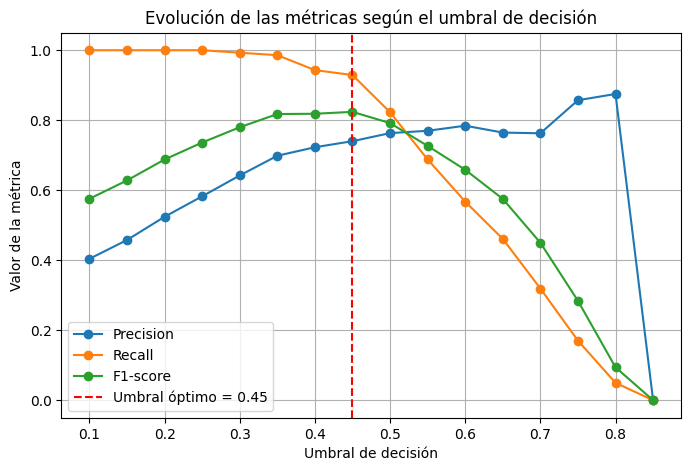

🔹 Umbral óptimo para F1: 0.45 (F1 = 0.824)


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Rango de umbrales de decisión
thresholds = np.arange(0.1, 0.9, 0.05)

# Calcular métricas para cada umbral
precisions = []
recalls = []
f1_scores = []

for t in thresholds:
    y_pred = (y_proba > t).astype(int)
    precisions.append(precision_score(y_test, y_pred))
    recalls.append(recall_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))

# Encontrar el mejor umbral
best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)

# Graficar
plt.figure(figsize=(8,5))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.plot(thresholds, f1_scores, label='F1-score', marker='o')
plt.axvline(best_t, color='red', linestyle='--', label=f'Umbral óptimo = {best_t:.2f}')
plt.title('Evolución de las métricas según el umbral de decisión')
plt.xlabel('Umbral de decisión')
plt.ylabel('Valor de la métrica')
plt.legend()
plt.grid(True)
plt.show()

print(f"Umbral óptimo para F1: {best_t:.2f} (F1 = {best_f1:.3f})")

Interpretación de la evolución de las métricas según el umbral de decisión

La gráfica muestra cómo cambian las tres métricas principales del modelo —precisión, recall y F1-score— a medida que se ajusta el umbral de decisión (es decir, el punto a partir del cual el modelo clasifica una observación como positiva).

* **La línea azul (precisión)** representa el porcentaje de
predicciones positivas que fueron correctas.
Se observa que la precisión aumenta al subir el umbral, porque el modelo se vuelve más exigente para clasificar como positivo, reduciendo falsos positivos.

*  **La línea naranja (recall)** muestra la capacidad del modelo para detectar todos los casos positivos reales.
Al contrario que la precisión, el recall disminuye al aumentar el umbral, ya que el modelo deja de identificar algunos casos positivos (aumentan los falsos negativos).

* **La línea verde (F1-score)** combina precisión y recall en una sola métrica, buscando el mejor equilibrio entre ambas.
En el gráfico, el F1 alcanza su valor máximo cerca del umbral 0.45 (indicado por la línea roja discontinua).

Este punto representa el umbral óptimo: el modelo logra el mejor balance entre detectar correctamente los casos positivos y mantener una buena precisión en sus predicciones.

En resumen, ajustar el umbral a 0.45 mejora el rendimiento global del modelo, haciéndolo más sensible sin sacrificar demasiado la exactitud.
Esto es especialmente útil en problemas donde es más importante detectar todos los casos relevantes (por ejemplo, fraudes, enfermedades, alertas, etc.) que evitar algunos falsos positivos.